# Permutation Invariant Networks Applied to Time Series

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm, trange

# Synthetic Univariate Times Series

In [ ]:
def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(False)

In [ ]:
def generate_univariate_dataset(t_max=500, nobs=500, rand_t=400, sep=10, n_classes=2):
  dataset = []
  labels = [] 
  times = np.arange(t_max)

  cols = ['lightskyblue', 'steelblue', 'dodgerblue', 'violet', 'mediumpurple', 'darkviolet', 'coral', 'tomato', 'salmon', 'pink']

  plt.figure(figsize=(10,5))

  for i in range(n_classes):
    tpattern = int(np.ceil(np.random.normal(50, 20, 1)[0]))
    trend = np.random.randint(-20, 20,size=1)[0]
    nseasons = int(np.ceil(t_max/tpattern))

    time = np.arange(tpattern)
    values = np.where(time < 10, time**3, (time-9)**2) 

    series = []
    for j in range(nseasons):
      for k in range(tpattern):
        series.append(values[k])

    series = series[:t_max] + np.arange(t_max)*(trend)
    
    for j in range(int(nobs/n_classes)):
      noise = np.random.randn(t_max)*200
      series_rand = series+ noise

      t_ind = np.random.choice(t_max, rand_t, replace=False)
      dataset.append(np.stack((times[t_ind], series_rand[t_ind]), axis=-1))
      labels.append(i)

    plt.plot(times, series_rand, color=cols[i], label='Example from class {}'.format(i))

  plt.legend()
  plt.show()


  return(dataset, labels)

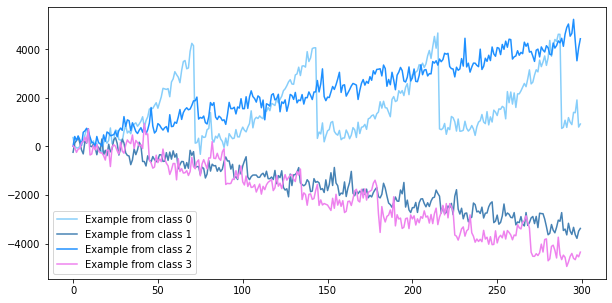

In [ ]:
dim_ts = 10
dim_ts_max = 300
dim_ds = 100
n_classes = 4

x, y = generate_univariate_dataset(dim_ts_max, dim_ds, dim_ts, n_classes=n_classes)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Deep Sets Model

In [ ]:
class DeepSet(nn.Module):
    def __init__(self, dim_input=2, dim_output=2, dim_hidden=128):
        super(DeepSet, self).__init__()
        self.dim_output = dim_output
        
        self.phi = nn.Sequential(
                nn.Linear(dim_input, dim_hidden),
                nn.ReLU(),
                nn.Linear(dim_hidden, dim_hidden),
                nn.ReLU(),
                nn.Linear(dim_hidden, dim_hidden),
                nn.ReLU(),
                nn.Linear(dim_hidden, dim_hidden))
        
        self.rho = nn.Sequential(
                nn.Linear(dim_hidden, dim_hidden),
                nn.ReLU(),
                nn.Linear(dim_hidden, dim_hidden),
                nn.ReLU(),
                nn.Linear(dim_hidden, dim_hidden),
                nn.ReLU(),
                nn.Linear(dim_hidden, dim_output))
    
    def forward(self, x):
      phi_output = self.phi(x)
      sum_output = phi_output.mean(0)
      rho_output = self.rho(sum_output)
      out = nn.LogSoftmax(dim=None)(rho_output)
      return out

In [ ]:
def positional_encoding(x_data, t_max, tau=10):
  num_timescales = tau // 2
  timescales = t_max**np.linspace(0, 1, num_timescales)
  transformed_list = []

  for x in x_data:
    times = x[:,0]
    scaled_times = np.array([i  / timescales for i in times])
    signal = np.concatenate((np.sin(scaled_times), np.cos(scaled_times)),-1)
    x_ = np.c_[signal, x[:,1]]
    transformed_list.append(x_)

  return transformed_list

### Training

In [ ]:
num_epochs = 10
dim_hidden = 128 

In [ ]:
model = DeepSet(dim_hidden=dim_hidden, dim_output=n_classes)
crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train(x_train, y_train, model, num_epochs, optimizer, crit):
        model.train()
        loss_val = float('inf')
        for j in range(num_epochs):
            sum_acc = 0.0
            for x, y in zip(x_train, y_train):

                X = torch.from_numpy(x).float()
                Y = torch.LongTensor([y])
                optimizer.zero_grad()
                f_X = model(X)

                loss_ = crit(f_X[None,:], Y)
                loss_val = loss_.item()

                sum_acc += (torch.argmax(f_X) == Y).float().numpy()[0]
                loss_.backward()
                optimizer.step()

            train_acc = sum_acc/len(y_train)
            print('After epoch {0} Train Accuracy: {1:0.3f} , Train Loss: {2:0.3f}'.format(j+1, train_acc, loss_val))

In [ ]:
train(x_train, y_train, model, num_epochs, optimizer, crit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


After epoch 1 Train Accuracy: 0.487 , Train Loss: 0.425
After epoch 2 Train Accuracy: 0.618 , Train Loss: 0.101
After epoch 3 Train Accuracy: 0.632 , Train Loss: 0.039
After epoch 4 Train Accuracy: 0.645 , Train Loss: 0.015
After epoch 5 Train Accuracy: 0.671 , Train Loss: 0.007
After epoch 6 Train Accuracy: 0.684 , Train Loss: 0.004
After epoch 7 Train Accuracy: 0.671 , Train Loss: 0.003
After epoch 8 Train Accuracy: 0.658 , Train Loss: 0.002
After epoch 9 Train Accuracy: 0.737 , Train Loss: 0.001
After epoch 10 Train Accuracy: 0.789 , Train Loss: 0.001


### Evaluation

In [ ]:
def test(x_test, y_test, model):
        model.eval()
        sum_acc = 0.0
        preds = []
        for x, y in zip(x_test, y_test):
          X = torch.from_numpy(x).float()
          Y = torch.LongTensor([y])
          f_X = model(X)
          sum_acc += (torch.argmax(f_X) == Y).float().numpy()[0]
          preds.append(torch.argmax(f_X).detach().numpy())
          
        test_acc = sum_acc/len(y_test)
        print('Final Test Accuracy: {0:0.3f}'.format(test_acc))
        return test_acc, preds

In [ ]:
acc, preds = test(x_test, y_test, model)

Final Test Accuracy: 0.850


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### With Positional Encoding

In [ ]:
tau = 2
t_max=dim_ts_max
num_epochs=20

x_train_pos = positional_encoding(x_train, t_max, tau)
x_test_pos = positional_encoding(x_test, t_max, tau)

model = DeepSet(dim_input = tau+1, dim_hidden=dim_hidden, dim_output=n_classes)
crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
train(x_train_pos, y_train, model, num_epochs, optimizer, crit)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


After epoch 0 Train Accuracy: 0.440 , Train Loss: 1.217
After epoch 10 Train Accuracy: 0.815 , Train Loss: 0.992


In [ ]:
acc, preds = test(x_test_pos, y_test, model)

Final Test Accuracy: 0.830


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Synthetic Multivariate Time Series

In [ ]:
def generate_multivariate_dataset(t_max=500, nobs=500, rand_t=400, sep=10, n_classes=2):
  dataset = []
  labels = [] 
  times = np.arange(t_max)

  for i in range(n_classes):

    #Modality 1
    tpattern = int(np.ceil(np.random.normal(50, 10, 1)[0]))
    trend = np.random.randint(-20, 20,size=1)[0]
    nseasons = int(np.ceil(t_max/tpattern))

    time = np.arange(tpattern)
    values = np.where(time < 10, time**3, (time-9)**2) 

    series = []
    for j in range(nseasons):
      for k in range(tpattern):
        series.append(values[k])

    series = series[:t_max] + np.arange(t_max)*(trend)

    #Modality 2
    tpattern_ = int(np.ceil(np.random.normal(50, 10, 1)[0]))
    trend_ = np.random.randint(-20, 20,size=1)[0]
    nseasons_ = int(np.ceil(t_max/tpattern_))

    time = np.arange(tpattern_)
    values_ = np.where(time < 10, time**3, (time-9)**2) 

    series_ = []
    for j in range(nseasons_):
      for k in range(tpattern_):
        series_.append(values_[k])

    series_ = series_[:t_max] + np.arange(t_max)*(trend_)

    #Modality 2
    tpattern__ = int(np.ceil(np.random.normal(50, 10, 1)[0]))
    trend__ = np.random.randint(-20, 20,size=1)[0]
    nseasons__ = int(np.ceil(t_max/tpattern__))

    time = np.arange(tpattern__)
    values__ = np.where(time < 10, time**3, (time-9)**2) 

    series__ = []
    for j in range(nseasons__):
      for k in range(tpattern__):
        series__.append(values__[k])

    series__ = series__[:t_max] + np.arange(t_max)*(trend__)
    

    for j in range(int(nobs/n_classes)):
      noise = np.random.randn(t_max)*200
      series_rand = series+ noise

      noise_ = np.random.randn(t_max)*200
      series_rand_ = series_ + noise_

      noise__ = np.random.randn(t_max)*200
      series_rand__ = series__ + noise__

      t_ind = np.random.choice(t_max, rand_t, replace=False)
      t_ind_ = np.random.choice(t_max, rand_t, replace=False)
      t_ind__ = np.random.choice(t_max, rand_t, replace=False)

      mod1 = np.stack((times[t_ind], series_rand[t_ind], [1]*len(times[t_ind])), axis=-1)
      mod2 = np.stack((times[t_ind_], series_rand_[t_ind_], [2]*len(times[t_ind_])), axis=-1)
      mod3 = np.stack((times[t_ind__], series_rand__[t_ind__], [3]*len(times[t_ind__])), axis=-1)

      dataset.append(np.concatenate((mod1, mod2, mod3)))
      labels.append(i)


  return(dataset, labels)

In [ ]:
dim_ts = 50
dim_ts_max = 1000
dim_ds = 100
n_classes = 5

x, y = generate_multivariate_dataset(dim_ts_max, dim_ds, dim_ts, n_classes=n_classes)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
model = DeepSet(dim_input=3, dim_hidden=dim_hidden, dim_output=n_classes)
crit = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

In [ ]:
train(x_train, y_train, model, num_epochs, optimizer, crit)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


After epoch 0 Train Accuracy: 0.487 , Train Loss: 0.383
After epoch 1 Train Accuracy: 0.588 , Train Loss: 0.328
After epoch 2 Train Accuracy: 0.637 , Train Loss: 0.320
After epoch 3 Train Accuracy: 0.637 , Train Loss: 0.359
After epoch 4 Train Accuracy: 0.713 , Train Loss: 0.322
After epoch 5 Train Accuracy: 0.725 , Train Loss: 0.322
After epoch 6 Train Accuracy: 0.738 , Train Loss: 0.314
After epoch 7 Train Accuracy: 0.725 , Train Loss: 0.313
After epoch 8 Train Accuracy: 0.725 , Train Loss: 0.306
After epoch 9 Train Accuracy: 0.738 , Train Loss: 0.329
After epoch 10 Train Accuracy: 0.725 , Train Loss: 0.312
After epoch 11 Train Accuracy: 0.725 , Train Loss: 0.309
After epoch 12 Train Accuracy: 0.725 , Train Loss: 0.292
After epoch 13 Train Accuracy: 0.725 , Train Loss: 0.275
After epoch 14 Train Accuracy: 0.738 , Train Loss: 0.261
After epoch 15 Train Accuracy: 0.750 , Train Loss: 0.255
After epoch 16 Train Accuracy: 0.750 , Train Loss: 0.236
After epoch 17 Train Accuracy: 0.750 , Tr

In [ ]:
acc, preds = test(x_test, y_test, model)

Final Test Accuracy: 0.700


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
